# Предсказание количества заказов такси в аэропортах

Имеются исторические данные о заказах такси в аэропортах. Цель заключается в построении модели для предсказания заказов на последующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Загрузка библиотек и выгрузка данных

Импортируем библиотеки

In [1]:
!pip install catboost --quiet

In [2]:
import time

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     TimeSeriesSplit
                                     )

from sklearn.metrics import mean_squared_error as mse

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor

RANDOM_STATE=12345

Выгрузим данные. Индексами будут являться даты

In [3]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.info()

## Подготовка данных и их анализ

### Первичный анализ данных

Для начала отсортируем индексы таблицы

In [5]:
df = df.sort_index()

Проверим, в хронологическом ли порядке теперь распределены данные. Если вернется True, значит все корректно

In [6]:
df.index.is_monotonic_increasing

True

Построим временной ряд

Text(0.5, 1.0, 'Исходный временной ряд')

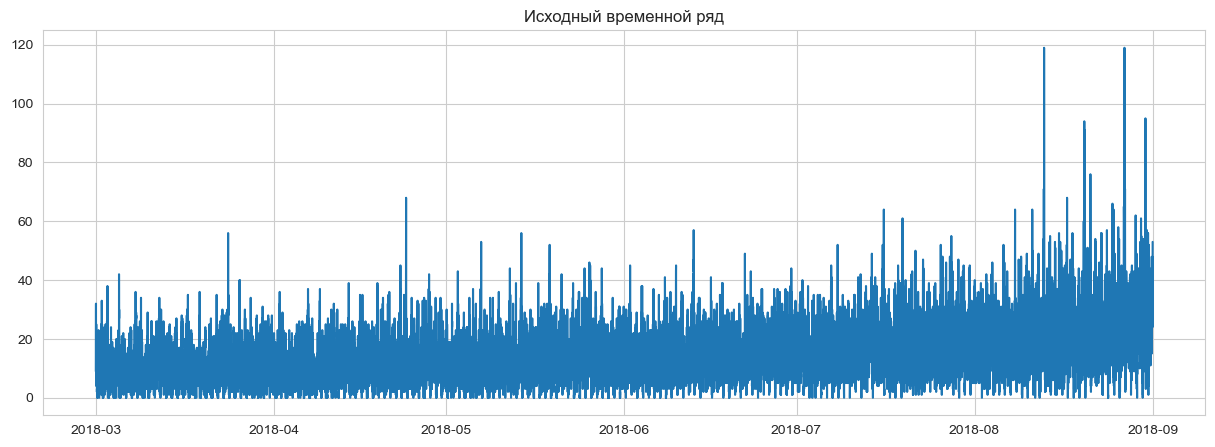

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['num_orders'])
plt.title('Исходный временной ряд')

Ресемплируем данные по часам

Text(0.5, 1.0, 'Временной ряд после ресемплинга по часам')

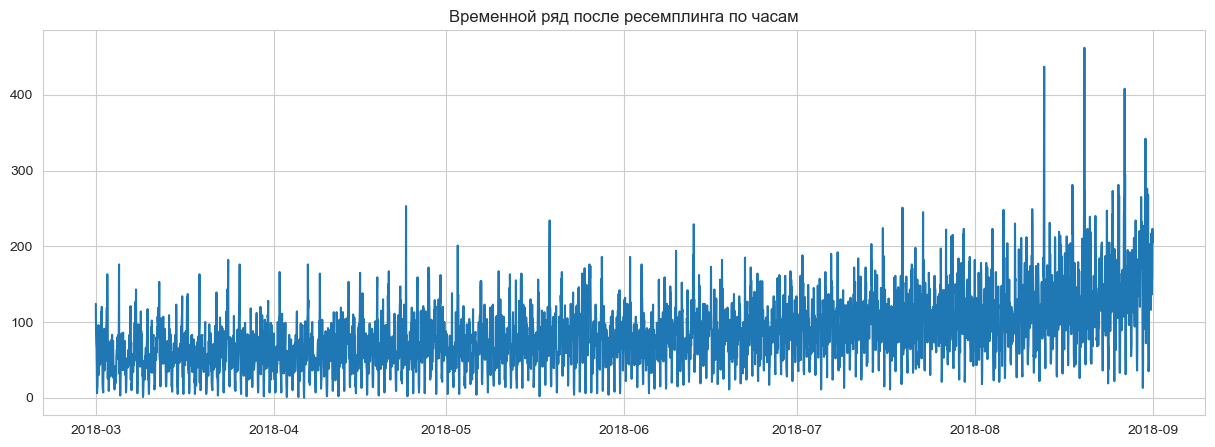

In [8]:
print(f'Количество строк до ресемплирования {df.shape[0]}')
df_h = df.resample('1H').sum()
print(f'Количество строк после ресемплирования {df.shape[0]}')
plt.figure(figsize=(15,5))
plt.plot(df_h.index, df_h['num_orders'])
plt.title('Временной ряд после ресемплинга по часам')

### Генерация и анализ признаков

Выделим из имеющегося временного ряда признаки для обучения: День недели, день, месяц, лаг в неделю, лаг в день, лаг в час, сколзящее среднее в одну неделю и один день. Далее удалим строки с пропусками.

После анализа признаков удалим ненужные

In [9]:
df_h['dayofweek'] = df_h.index.dayofweek

df_h['day'] = df_h.index.day

df_h['month'] = df_h.index.month

df_h['lag_1w'] = df_h['num_orders'].shift(168) # 168 – количество часов в неделе

df_h['lag_1d'] = df_h['num_orders'].shift(24)

df_h['lag_1h'] = df_h['num_orders'].shift(1)

df_h['rolling_w'] = df_h['num_orders'].shift().rolling(168).mean()

df_h['rolling_d'] = df_h['num_orders'].shift().rolling(24).mean()

print(f'{df_h["rolling_w"].isna().sum()} строк с пропусками следует удалить')

df_h = df_h.dropna()


В связи с очисткой данных от пропусков первая дата стала 8 марта, нежели 1 число

Построим скользящие средние по дням и неделям

Text(0.5, 1.0, 'Скользящие средние по дням и неделям за весь период')

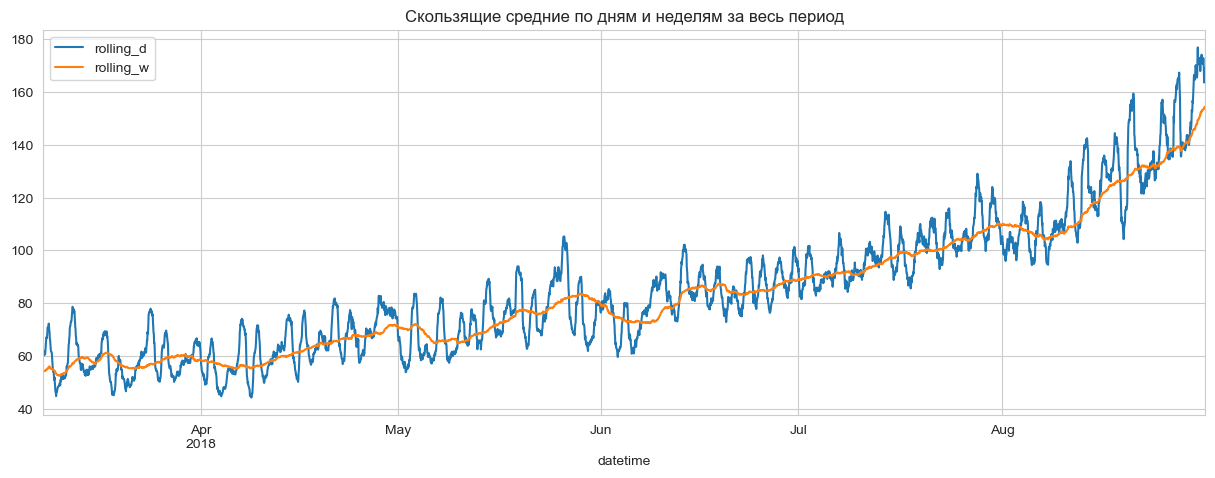

In [10]:
df_h[['rolling_d','rolling_w']].plot(grid=True, figsize=(15,5))
plt.title('Скользящие средние по дням и неделям за весь период')

Виден возрастающий тренд. Попробуем выделить любой отдельный целый месяц и рассмотреть его подробнее. Помимо этого видно, что у нас данные не за полный год. В связи с тем, что сезонность неполного года не видна, можно смело отказаться от признака, отражающего месяц

In [11]:
df_h = df_h.drop('month', axis=1)

In [12]:
df_april = df_h.loc['2018-04-01':'2018-04-30',:]

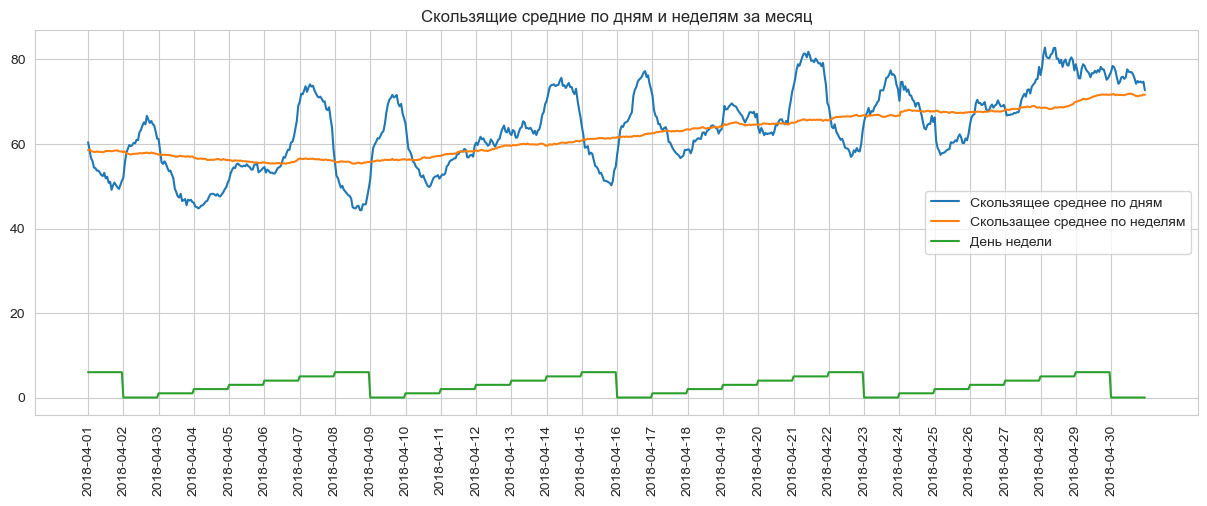

In [13]:
plt.figure(figsize=(15,5))

plt.plot(df_april.index,
         df_april[['rolling_d', 'rolling_w', 'dayofweek']])

plt.title('Скользящие средние по дням и неделям за месяц')
plt.xticks(df_april.index[::24], rotation=90)
plt.legend(['Скользящее среднее по дням', 'Скользащее среднее по неделям', 'День недели'])
plt.show()

Видно, что ряд чувствителен ко дню недели. Рассмотрим подробно два дня

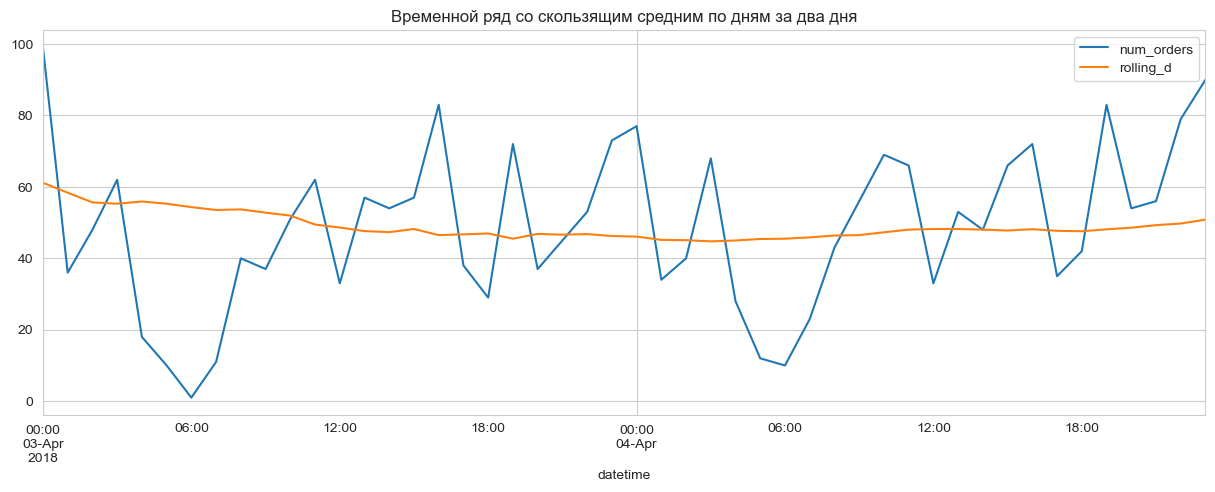

In [14]:
df_h.loc['2018-04-03':'2018-04-04', ['num_orders', 'rolling_d']].plot(figsize=(15,5))
plt.xticks(df_h.loc['2018-04-03':'2018-04-04',:].index[::24])

plt.title('Временной ряд со скользящим средним по дням за два дня')
plt.show()

Видно, что также имеется зависимость от часа в сутках: в 6 утра заказов минимальное количество, около 11:00 и 19:00 число заказов максимальное.

### Декомпозиция данных

Построим декомпозицию данных для видения общей картины данных

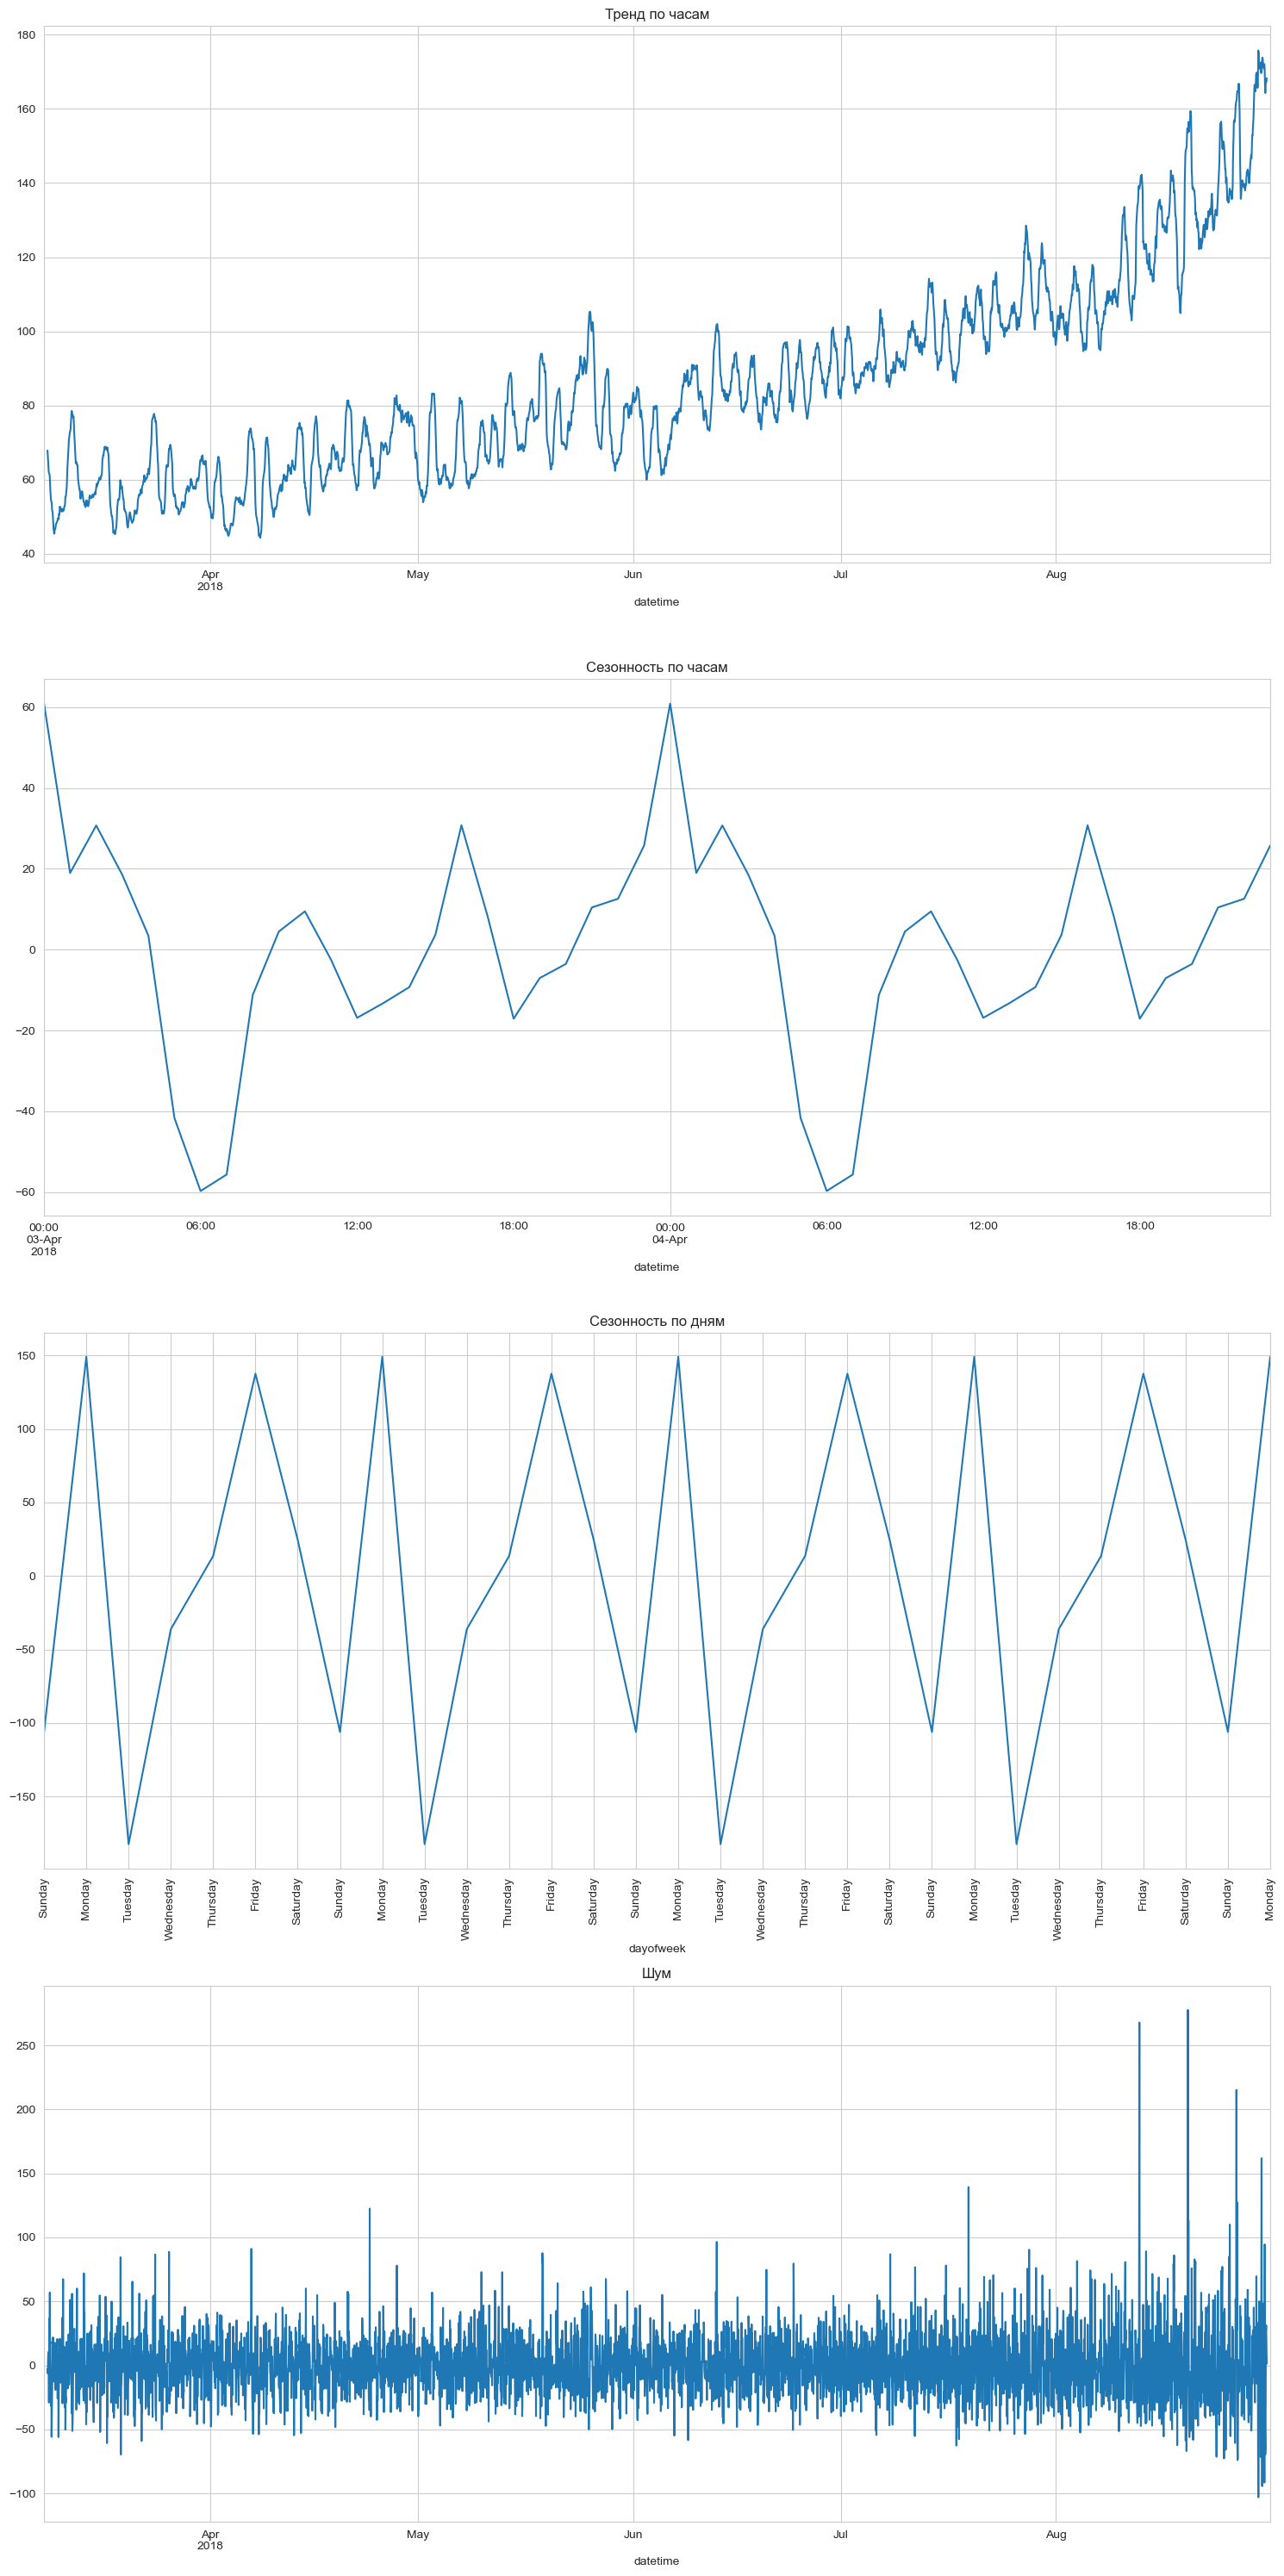

In [15]:
df_day = df.resample('1D').sum()

decomposed_day = seasonal_decompose(df_day)
decomposed_hour = seasonal_decompose(df_h['num_orders'])

plt.figure(figsize=(15, 30))

plt.subplot(411)
decomposed_hour.trend.plot(ax=plt.gca())
plt.title('Тренд по часам')

plt.subplot(412)
decomposed_hour.seasonal['2018-04-03':'2018-04-04'].plot(ax=plt.gca())
plt.title('Сезонность по часам')

plt.subplot(413)
dec_day = decomposed_day.seasonal['2018-04-01':'2018-04-30']
dec_day.plot(ax=plt.gca())
plt.xticks(ticks= dec_day.index,
           labels = dec_day.index.day_name(),
           rotation=90)
plt.xlabel("dayofweek")
plt.title('Сезонность по дням')

plt.subplot(414)
decomposed_hour.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

**Промежуточный вывод**
По графикам можно сделать следующие выводы:

– Виден возрастающий тренд по заказам в каждом месяце
– Меньше всего заказов по утрам в 6:00, далее идет рост
– Больше всего заказов приходится на полночь
– Больше всего заказов по понедельникам и пятницам
– Меньше всего заказов по средам и воскресеньям

## Обучение моделей

Выделим из данных признаки и целевой признак

In [16]:
train, test = train_test_split(df_h,
                               test_size=.1,
                               shuffle=False,
                               )

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Линейная регрессия

Обучим линейную регрессию

In [17]:
model_linear = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
params = {}
model_linear = GridSearchCV(estimator=model_linear,
                            cv=tscv,
                            scoring='neg_root_mean_squared_error',
                            param_grid=params
                             )
s = time.time()
model_linear.fit(X_train, y_train)
e = time.time()
print('LinearRegression:')
#print(f'Лучшие параметры: {model_linear.best_params_}')
print(f'Скорость обучения: {round(e-s,5)}')
s = time.time()
pred = model_linear.predict(X_train)
e = time.time()
print(f'Скорость предсказания: {round(e-s,3)}')
print(f'RMSE для лучших параметров:', round(model_linear.best_score_*(-1), 2))

### LightGBM

In [18]:
params_lgb = {
    'learning_rate': [0.1,0.11,0.12,0.13,0.14,0.15],
    'n_estimators': range(50,401,50)
}

lgbst = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE)

model_lgb = GridSearchCV(estimator=lgbst,
                         param_grid=params_lgb,
                         cv=tscv,
                         n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         )
s = time.time()
model_lgb.fit(X_train, y_train)
e = time.time()
print('LGBMRegressor:')
print(f'Лучшие параметры: {model_lgb.best_params_}')
print(f'Скорость обучения: {round(e-s,2)}')
s = time.time()
pred = model_lgb.predict(X_train)
e = time.time()
print(f'Скорость предсказания модели: {round(e-s,2)}')
print(f'RMSE для лучших параметров:', round(model_lgb.best_score_*(-1), 0))

### Catboost

In [19]:
params_cat = {
    'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01,0.02,0.03,0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}


catboost = CatBoostRegressor(loss_function="RMSE", iterations=100, random_state=RANDOM_STATE)


model_cat_boost = GridSearchCV(estimator=catboost,
                               param_grid=params_cat,
                               cv=tscv,
                               n_jobs=-1,
                               scoring='neg_root_mean_squared_error',
                               )
s = time.time()
model_cat_boost.fit(X_train,
                    y_train,
                    )
e = time.time()

print('CatBoostRegressor:')
print(f'Лучшие параметры: {model_cat_boost.best_params_}')
print(f'Скорость обучения: {round(e-s,2)}')
print(f'RMSE для лучших параметров:', round(model_cat_boost.best_score_*(-1), 2))
s = time.time()
pred = model_cat_boost.predict(X_train)
e = time.time()
print(f'Скорость предсказания модели: {round(e-s,2)}')

Лучшей моделью оказалась модель Линейной регрессии. Протестируем ее на тестовой выборке.

## Тестирование

Протестируем модель на тестовой выборке

In [20]:
print(f'{round(mse(y_test, model_linear.predict(X_test), squared=False),2)}')

Модель показала чуть большее значение отклонения, переобучение отсутствует. Проверим модель на адекватность

In [24]:
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print(mse(y_test, pred_previous, squared=False))

Значение на 60 процентов выше, чем предсказанное значение регрессией. Наша модель прошла проверку на адекватность

## Вывод

Были проанализированы данные заказов такси, из них выделены выводы:

– У данных имеется возрастающий тренд по заказам в каждом месяце;
– Меньше всего заказов по утрам в 6:00, далее идет рост;
– Больше всего заказов приходится на полночь;
– Больше всего заказов по понедельникам и пятницам;
– Меньше всего заказов по средам и воскресеньям.

Были протестированы три модели машинного обучения, лучше всего для временных рядов показала себя модель линейной регрессии.
**Результаты обучения**

Скорость обучения – 16 миллисекунд
Среднеквадратичное отклонение по тестовой выборке – 34.93
Скорость предсказания: Примерно 8 миллисекунд